In [63]:
'''
# Check if these need to be installed
pip install wget
pip install requests
pip install azure-cognitiveservices-search-imagesearch
'''

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=d91dd9b1febaa6ab3bad01dad180e8e13eca892a132f17923b3ef241a74cf5e6
  Stored in directory: /Users/mton/Library/Caches/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [54]:
import os as os
from requests import request
# request('GET','http://localhost:5000/')
# TODO : Fix this trash => Ugh, hardcoding my key for now lol
key = os.environ.get('AZURE_SEARCH_KEY', '2414bd8a0aaa4f609964be7106a58890')

In [15]:

from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
from fastai.vision.core import L #foundation.py

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = request('GET', search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()
#      for each in search_results['value']:
#            print(each)
     return L(search_results['value'])

In [60]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
from wget import download
dest = 'images/grizzly.jpg'
isdir = os.path.isdir(dest)
print(isdir)
dir = download(ims[0])
print(dir)

im = Image.open(dir)  # type: ignore
im.to_thumb(128, 128)

In [1]:
from fastai.vision.utils import download_images
from fastcore.utils import Path

bear_types = 'grizzly', 'black', 'teddys'
path = Path('Bears')
print(path)
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

Bears


In [2]:
from fastai.vision.utils import get_image_files
from fastai.vision.utils import verify_images
print(bear_types)
path = Path('Bears')
fns = get_image_files(path)
# originally 384 imaged
print(len(fns.items))
# Some downloads will be corrupt, let's check for them
failed = verify_images(fns)
print(len(failed.items))
# Some downloads will be corrupt, let's check for them
# 328 after removing 56 corrupt images
failed.map(Path.unlink)

('grizzly', 'black', 'teddys')
328
0


(#0) []

In [3]:
from fastai.vision.utils import DataBlock
from fastai.vision.data import ImageBlock
from fastai.vision.utils import CategoryBlock
from fastai.vision.utils import get_image_files
from fastai.vision.utils import RandomSplitter
from fastai.vision.utils import parent_label
from fastai.vision.augment import Resize

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   # type: ignore
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # set seed so that the 20% validation data is always the same
    get_y=parent_label, # y is the label, i.e. the dependent variable to x
    item_tfms=Resize(128)  # type: ignore : tensors have to be the same size, Preprocess and Resize to 128x128
)

dls = bears.dataloaders(path)

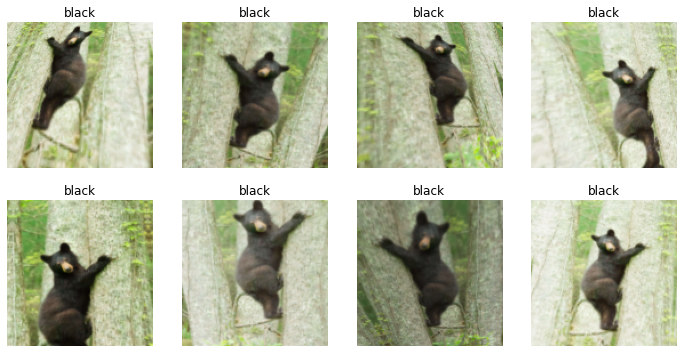

In [4]:
from fastai.vision.augment import aug_transforms
from fastai.vision.augment import RandomResizedCrop

# data augmentation - randomnly transform, warp, brighten, contrast ... etc
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),   # type: ignore
    batch_tfms=aug_transforms(mult=2)
)

dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [6]:
from fastai.vision.learner import vision_learner
from fastai.vision.learner import error_rate
from fastai.vision.models import resnet50, ResNet50_Weights

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50(weights=ResNet50_Weights.DEFAULT)

learn = vision_learner(dls, resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/mton/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
from fastai.vision.learner import Learner

learn.fine_tune(4)